
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [20]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [9]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha = ha.dropna()
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [18]:
#ha.dtypes

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [108]:
# kNN
X = ha.drop(['cp', 'output'], axis=1)
y = ha['cp']

ct = ColumnTransformer([
    ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
    ("dummify", OneHotEncoder(drop='first', sparse_output=False), ["restecg"])
], remainder="passthrough").set_output(transform = "pandas")

knn_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn", KNeighborsClassifier())
])
knn_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalach']),
                                                 ('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['restecg'])])),
                ('knn', KNeighborsClassifier())])

In [109]:
param_grid = {'knn__n_neighbors': range(1, 31)}
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='roc_auc_ovr')
grid_search.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardize',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalach']),
                                                                        ('dummify',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['restecg'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(1, 31)},
             scoring='roc_auc_ovr')

In [110]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'knn__n_neighbors': 5}


In [111]:
best_knn = Pipeline([
    ('preprocess', ct),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

best_knn.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalach']),
                                                 ('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['restecg'])])),
                ('knn', KNeighborsClassifier())])

In [112]:
# Decision Tree
ct = ColumnTransformer([
    ("dummify", OneHotEncoder(drop='first', sparse_output=False), ["restecg"])
], remainder="passthrough").set_output(transform = "pandas")

dt_pipeline = Pipeline([
    ("preprocessing", ct),
    ("tree", DecisionTreeClassifier(random_state=42))
])

param_grid = {
    "tree__max_depth": range(1, 21),
    "tree__min_samples_split": [2, 5, 10],
    "tree__min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='roc_auc_ovr')
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'tree__max_depth': 3, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}


In [113]:
best_dt = Pipeline([
    ("preprocessing", ct),
    ("tree", DecisionTreeClassifier(max_depth=3, min_samples_leaf=1, min_samples_split=2, random_state=42))
])
best_dt.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['restecg'])])),
                ('tree', DecisionTreeClassifier(max_depth=3, random_state=42))])

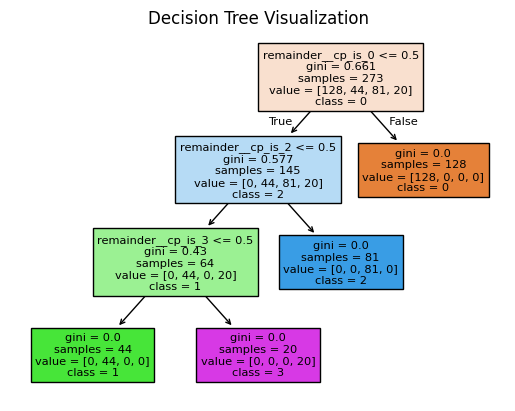

In [114]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

class_names = [str(cls) for cls in fitted_tree.classes_]

fitted_tree = best_dt.named_steps['tree']
plot_tree(
    fitted_tree,
    feature_names=ct.get_feature_names_out(),
    class_names=class_names,  # Use string class names
    filled=True
)
plt.title("Decision Tree Visualization")
plt.show()

- If the condition (remainder__output <= 0.5) is satisfied, the observation goes to the ledt branch, otherwise, to the right.
- Samples indicates the total number of samples in the dataset at this step
- Value represents the counts of each class in this step
- At the end, the left branch is dominated by class 1 while the right branch is dominated by class 3


In [115]:
# LDA

ct = ColumnTransformer([
    ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
    ("dummify", OneHotEncoder(drop='first', sparse_output=False), ["restecg"])
], remainder="passthrough").set_output(transform="pandas")


lda_pipeline = Pipeline([
    ("preprocessing", ct),
    ("lda", LinearDiscriminantAnalysis())
])

In [117]:
param_grid = {
    "lda__solver": ["lsqr", "eigen"],
    "lda__shrinkage": ["auto", 0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(lda_pipeline, param_grid, cv=5, scoring="roc_auc_ovr")
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}


In [118]:
best_lda = Pipeline([
    ("preprocessing", ct),
    ("lda", LinearDiscriminantAnalysis(shrinkage="auto", solver="lsqr"))
])

best_lda.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalach']),
                                                 ('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['restecg'])])),
                ('lda',
                 LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'))])

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [121]:
# cp is 0
ha['cp_is_0'] = (ha['cp'] == 0).astype(int)

X = ha.drop(['cp', 'cp_is_0', 'output'], axis=1)
y = ha['cp_is_0']

ct = ColumnTransformer([
    ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
    ("dummify", OneHotEncoder(drop='first', sparse_output=False), ["restecg"])
], remainder="passthrough").set_output(transform="pandas")

lr_pipeline = Pipeline([
    ("preprocessing", ct),
    ("lr", LogisticRegression(random_state=42))
])

cv0_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='f1')
df0_scores = pd.DataFrame({
    'Type of Chest Pain': ['cp_is_0'],
    'F1 score': [np.mean(cv0_scores)]
})
df0_scores

,Type of Chest Pain,F1 score
0,cp_is_0,1.0


In [122]:
# cp is 1
ha['cp_is_1'] = (ha['cp'] == 1).astype(int)

X = ha.drop(['cp', 'cp_is_1', 'output'], axis=1)
y = ha['cp_is_1']

cv1_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='f1')
df1_scores = pd.DataFrame({
    'Type of Chest Pain': ['cp_is_1'],
    'F1 score': [np.mean(cv1_scores)]
})
df1_scores

,Type of Chest Pain,F1 score
0,cp_is_1,0.963235


In [123]:
# cp is 2
ha['cp_is_2'] = (ha['cp'] == 2).astype(int)

X = ha.drop(['cp', 'cp_is_2', 'output'], axis=1)
y = ha['cp_is_2']

cv2_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='f1')
df2_scores = pd.DataFrame({
    'Type of Chest Pain': ['cp_is_2'],
    'F1 score': [np.mean(cv2_scores)]
})
df2_scores

,Type of Chest Pain,F1 score
0,cp_is_2,1.0


In [124]:
# cp is 3
ha['cp_is_3'] = (ha['cp'] == 3).astype(int)

X = ha.drop(['cp', 'cp_is_3', 'output'], axis=1)
y = ha['cp_is_3']

cv3_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='f1')
df3_scores = pd.DataFrame({
    'Type of Chest Pain': ['cp_is_3'],
    'F1 score': [np.mean(cv3_scores)]
})
df3_scores

,Type of Chest Pain,F1 score
0,cp_is_3,0.502857


In [125]:
scores = pd.concat([df0_scores, df1_scores, df2_scores, df3_scores], ignore_index=True)
scores

,Type of Chest Pain,F1 score
0,cp_is_0,1.000000
1,cp_is_1,0.963235
2,cp_is_2,1.000000
3,cp_is_3,0.502857


OvR approach is best at distinguishing type 0 and 2 chest pain



## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [126]:
ha_filtered = ha[ha['cp'].isin([0, 1])]  # Only include rows where cp is 0 or 1
ha_filtered = ha_filtered.dropna()

X_filtered = ha_filtered[["age", "sex", "trtbps", "chol", "restecg", "thalach"]]
y_filtered = ha_filtered['cp']

ct = ColumnTransformer([
    ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
    ("dummify", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ["restecg"])
], remainder="passthrough").set_output(transform="pandas")

lr_pipeline = Pipeline([
    ("preprocessing", ct),
    ("lr", LogisticRegression(random_state=42))
])

In [127]:
cv1_roc_auc = cross_val_score(lr_pipeline, X_filtered, y_filtered, cv=5, scoring='roc_auc')

df1_scores = pd.DataFrame({
    'Comparasion of Chest Pain': ['0 vs. 1'],
    'Mean ROC-AUC score': [np.mean(cv1_roc_auc)]
})
df1_scores

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Comparasion of Chest Pain,Mean ROC-AUC score
0,0 vs. 1,0.771013


In [128]:
ha_filtered = ha[ha['cp'].isin([0, 2])]  # Only include rows where cp is 0 or 1
ha_filtered = ha_filtered.dropna()

X_filtered = ha_filtered[["age", "sex", "trtbps", "chol", "restecg", "thalach"]]
y_filtered = ha_filtered['cp']

ct = ColumnTransformer([
    ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
    ("dummify", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ["restecg"])
], remainder="passthrough").set_output(transform="pandas")

lr_pipeline = Pipeline([
    ("preprocessing", ct),
    ("lr", LogisticRegression(random_state=42))
])

cv2_roc_auc = cross_val_score(lr_pipeline, X_filtered, y_filtered, cv=5, scoring='roc_auc')

df2_scores = pd.DataFrame({
    'Comparasion of Chest Pain': ['0 vs. 2'],
    'Mean ROC-AUC score': [np.mean(cv2_roc_auc)]
})
df2_scores

,Comparasion of Chest Pain,Mean ROC-AUC score
0,0 vs. 2,0.652816


In [129]:
ha_filtered = ha[ha['cp'].isin([0, 3])]  # Only include rows where cp is 0 or 1
ha_filtered = ha_filtered.dropna()

X_filtered = ha_filtered[["age", "sex", "trtbps", "chol", "restecg", "thalach"]]
y_filtered = ha_filtered['cp']

ct = ColumnTransformer([
    ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
    ("dummify", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ["restecg"])
], remainder="passthrough").set_output(transform="pandas")

lr_pipeline = Pipeline([
    ("preprocessing", ct),
    ("lr", LogisticRegression(random_state=42))
])

cv3_roc_auc = cross_val_score(lr_pipeline, X_filtered, y_filtered, cv=5, scoring='roc_auc')

df3_scores = pd.DataFrame({
    'Comparasion of Chest Pain': ['0 vs. 3'],
    'Mean ROC-AUC score': [np.mean(cv3_roc_auc)]
})
df3_scores

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Comparasion of Chest Pain,Mean ROC-AUC score
0,0 vs. 3,0.712385


In [130]:
summary = pd.concat([df1_scores, df2_scores, df3_scores], ignore_index=True)
summary

,Comparasion of Chest Pain,Mean ROC-AUC score
0,0 vs. 1,0.771013
1,0 vs. 2,0.652816
2,0 vs. 3,0.712385


OvO approach is best at distinguishing tehe 0 vs. 1 pair